In [ ]:
!pip install mendelai-brat-parser

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

nltk.download('universal_tagset')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import regex as re
from collections import Counter
import math

from google.colab import files
import zipfile
import glob

from brat_parser import get_entities_relations_attributes_groups

from nltk.tag import pos_tag, map_tag

from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from brat_parser import get_entities_relations_attributes_groups

import gensim
import gensim.downloader as api
from gensim.models import Word2Vec

from sklearn.metrics import classification_report
from keras.utils.np_utils import to_categorical

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# Neural network imports.
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input, Dropout
from keras.layers import TimeDistributed
from keras.layers import Concatenate
from keras.layers import LSTM, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model, Input

# **Relations Dataframe**

In [ ]:
# Import the datataset, created in a previous moment, (essay_relation_dataset.csv) 
# containing an entry for each relation of the Stab and Gurevych dataset.
# Each entry is composed as: 
# (type,doc_id,supporting_text,supporting_type,supporting_sentence_id,supporting_section_length,supported_text,supported_type,supported_sentence_id,supported_section_length)
# where type is the relation tipe (attack, support, none).
# supporting and supported refer to the two section of the corpus that are in a relation:
# text refers to their original texts, type if they are a premise or a claim, the length to the number of sentences in the arg. section after the first one,  and sentence_id
# indicates the position in the corpus of the sentence that contains them.
print('\nImport essay_relation_dataset.csv\n')
uploaded = files.upload()


Import essay_relation_dataset.csv



Saving essay_relation_dataset.csv to essay_relation_dataset.csv


In [ ]:
# Import the statistics and positions information of the sentences to classify.
print('\nImport relation_statistic.csv\n')
upload = files.upload()

# Import the BOW of the bigrams of the sentences to classify.
print('\nImport relation_Bigram.csv\n')
upload = files.upload()

# Import the BOW of the POS of the sentences to classify.
print('\nImport relation_POS.csv\n')
upload = files.upload()


Import relation_statistic.csv




Import relation_Bigram.csv




Import relation_POS.csv



In [ ]:
# Import the feature relative to the POS tag of the sentences not to use.
# (drop_claim_premise_named_entity.txt).
print('\nImport drop_relation_POS.txt\n')
upload = files.upload()


Import drop_relation_POS.txt



In [ ]:
# Import the original Stab and Gurevych dataset (2017 version).

uploaded = files.upload()

Saving ArgumentAnnotatedEssays-2.0.zip to ArgumentAnnotatedEssays-2.0.zip


In [ ]:
# The imported dataset is here directly used.
# MajorClaim have been removed from the argumentations in the imported dataset (they don't have labeled relations).

relation_ann_dataset=pd.read_csv('essay_relation_dataset.csv')

In [ ]:
relation_ann_dataset.head()

,type,doc_id,supporting_text,supporting_type,supporting_sentence_id,supporting_section_length,supported_text,supported_type,supported_sentence_id,supported_section_length
0,supports,0,What we acquired from team work is not only ho...,Premise,5,0,"through cooperation, children can learn about ...",Claim,4,0
1,supports,0,"During the process of cooperation, children ca...",Premise,6,0,"through cooperation, children can learn about ...",Claim,4,0
2,supports,0,All of these skills help them to get on well w...,Premise,7,0,"through cooperation, children can learn about ...",Claim,4,0
3,supports,0,the significance of competition is that how to...,Premise,8,0,competition makes the society more effective,Claim,9,0
4,supports,0,when we consider about the question that how t...,Premise,10,0,"without the cooperation, there would be no vic...",Claim,14,0


In [ ]:
# Print some the dataset characteristics.
print("Informations about the dataset:\n")
print("Number element in the dataset: {}".format(len(relation_ann_dataset)))
print("Number effective relations: {}".format(len(relation_ann_dataset.loc[relation_ann_dataset['type']!='None'])))
print("Number support relations: {}".format(len(relation_ann_dataset.loc[relation_ann_dataset['type']=='supports'])))
print("Number attack relations: {}".format(len(relation_ann_dataset.loc[relation_ann_dataset['type']=='attacks'])))
print("Number premise supported by other premises: {}".format(len(relation_ann_dataset.loc[(relation_ann_dataset['supported_type']=='Premise')&(relation_ann_dataset['type']=='supports')])))

Informations about the dataset:

Number element in the dataset: 6243
Number effective relations: 3832
Number support relations: 3613
Number attack relations: 219
Number premise supported by other premises: 667


# **Original dataset**

In [ ]:
# Function to extract zip file.
# Takes in input the path to the zip file (path_zip) and the one to store the destination directory (path_destination).

def extract_zip(path_zip,path_destination):
  with zipfile.ZipFile(path_zip, 'r') as zip_ref:
    zip_ref.extractall(path_destination)


In [ ]:
# Extract zip file (two zip files one inside the other).

extract_zip('ArgumentAnnotatedEssays-2.0.zip','ArgumentAnnotatedEssays-2.0')

extract_zip('ArgumentAnnotatedEssays-2.0/ArgumentAnnotatedEssays-2.0/brat-project-final.zip','ArgumentAnnotatedEssays')

# **Create and visualize the required Dataframe**

In [ ]:
# Extract the list of text files of the essays in the dataset.
txt_files = sorted(glob.glob("ArgumentAnnotatedEssays/brat-project-final/essay*.txt"))

# Extract the list of text files of the essays in the dataset.
ann_files = sorted(glob.glob("ArgumentAnnotatedEssays/brat-project-final/essay*.ann"))

In [ ]:
# List of text files of the essays.
txt_files[0:5]

['ArgumentAnnotatedEssays/brat-project-final/essay001.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay002.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay003.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay004.txt',
 'ArgumentAnnotatedEssays/brat-project-final/essay005.txt']

In [ ]:
# List of the annotated files of the essays.
ann_files[0:5]

['ArgumentAnnotatedEssays/brat-project-final/essay001.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay002.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay003.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay004.ann',
 'ArgumentAnnotatedEssays/brat-project-final/essay005.ann']

In [ ]:
# Transfor the ann files into four dictionaries.
ann_disctionaries=[get_entities_relations_attributes_groups(file) for file in ann_files]

# Transform the first dictionary (entities) obtained from each ann file into a dataset.
essay_ann_datasets = [pd.DataFrame.from_dict(entities, orient='index') for entities,_,_,_ in ann_disctionaries]

In [ ]:
# Sort the lists composed of a (entity) dataset for each essay.
essay_ann_datasets=[dataset.sort_values(by='span', key=lambda col: col.map(lambda x: x[0][0])) for dataset in essay_ann_datasets]  

# Add a coloumn into the dataset that identifies the document
for i in range(len(essay_ann_datasets)):
  essay_ann_datasets[i].insert(0,'doc_id',i)

# Create a common dataset
essay_argument_dataset = pd.concat(essay_ann_datasets)

In [ ]:
# Sobstitue the values in the "span" feature (substitute each tuple with its first inner tuple)
for i in range(len(essay_argument_dataset.index)):
  essay_argument_dataset['span'][i]=essay_argument_dataset['span'][i][0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
essay_argument_dataset.head()

,doc_id,id,type,span,text
T1,0,T1,MajorClaim,"(503, 575)",we should attach more importance to cooperatio...
T3,0,T3,Claim,"(591, 714)","through cooperation, children can learn about ..."
T4,0,T4,Premise,"(716, 851)",What we acquired from team work is not only ho...
T5,0,T5,Premise,"(853, 1086)","During the process of cooperation, children ca..."
T6,0,T6,Premise,"(1088, 1191)",All of these skills help them to get on well w...


# **Word list of the Corpus**

In [ ]:
# List of texts of the essays
files_text=[open(file).read() for file in txt_files]

In [ ]:
# Get the start and finish points of each argumentative section of each of the text.
# Also get the type of each argumentative section.
# This points are indicated in the "span" coloumn of the Dataframe of the annotation.

sorted_span=[list(essay_argument_dataset.loc[essay_argument_dataset['doc_id'] == i,['span','type']].values) for i in range(len(ann_files))]

In [ ]:
sorted_span[0]

[array([(503, 575), 'MajorClaim'], dtype=object),
 array([(591, 714), 'Claim'], dtype=object),
 array([(716, 851), 'Premise'], dtype=object),
 array([(853, 1086), 'Premise'], dtype=object),
 array([(1088, 1191), 'Premise'], dtype=object),
 array([(1212, 1301), 'Premise'], dtype=object),
 array([(1332, 1376), 'Claim'], dtype=object),
 array([(1387, 1492), 'Premise'], dtype=object),
 array([(1549, 1846), 'Premise'], dtype=object),
 array([(1927, 1992), 'Claim'], dtype=object),
 array([(2154, 2231), 'MajorClaim'], dtype=object)]

In [ ]:
# Tranform the couples of points ((start,end) of each section) to a list (separator of different section).

span_points=[]

for i in range(len(sorted_span)):
  list_points=[sep for sub in sorted_span[i] for sep in sub[0]]
  # Insert starting point of the text
  list_points.insert(0,0)
  list_points.append(len(files_text[i]))
  span_points.append(list_points)

In [ ]:
span_points[0]

[0,
 503,
 575,
 591,
 714,
 716,
 851,
 853,
 1086,
 1088,
 1191,
 1212,
 1301,
 1332,
 1376,
 1387,
 1492,
 1549,
 1846,
 1927,
 1992,
 2154,
 2231,
 2232]

In [ ]:
# Separate the texts at the point indicated for the different sections

split_text=[]

for z in range(len(files_text)):
  split_text.append([files_text[z][i: j] for i, j in zip(span_points[z], span_points[z][1:])])

In [ ]:
split_text[0][0:10]

["Should students be taught to compete or to cooperate?\n\nIt is always said that competition can effectively promote the development of economy. In order to survive in the competition, companies continue to improve their products and service, and as a result, the whole society prospers. However, when we discuss the issue of competition or cooperation, what we are concerned about is not the whole society, but the development of an individual's whole life. From this point of view, I firmly believe that ",
 'we should attach more importance to cooperation during primary education',
 '.\nFirst of all, ',
 'through cooperation, children can learn about interpersonal skills which are significant in the future life of all students',
 '. ',
 'What we acquired from team work is not only how to achieve the same goal with others but more importantly, how to get along with others',
 '. ',
 'During the process of cooperation, children can learn about how to listen to opinions of others, how to com

In [ ]:
# Get the list of the words of each essay.

X_essay_word_list=[]

for i in range(len(split_text)):
  
  essay_word_list=[]

  # Remove title from essay considered (splitted_text)
  no_title=[re.sub(r".*\n\n","",text) for text in split_text[i]]

  for section in no_title:

    # Divide the text into token.
    seq=nltk.word_tokenize(section.lower())

    essay_word_list+=seq

  X_essay_word_list.append(essay_word_list)

In [ ]:
X_essay_word_list[0][80:120]

['i',
 'firmly',
 'believe',
 'that',
 'we',
 'should',
 'attach',
 'more',
 'importance',
 'to',
 'cooperation',
 'during',
 'primary',
 'education',
 '.',
 'first',
 'of',
 'all',
 ',',
 'through',
 'cooperation',
 ',',
 'children',
 'can',
 'learn',
 'about',
 'interpersonal',
 'skills',
 'which',
 'are',
 'significant',
 'in',
 'the',
 'future',
 'life',
 'of',
 'all',
 'students',
 '.',
 'what']

# **Find out sentences list**

In [ ]:
# Get the list of all the sentences.

sentence_list=[]

# Get the list of the id of the essay for each of the sentences of the corpus.
essay_id_list=[]


for essay_id in range(len(X_essay_word_list)):
  sentence=""

  for word_id in range(len(X_essay_word_list[essay_id])):
    
    word=X_essay_word_list[essay_id][word_id]

    # Add to the sentence every word that is not a simple \n or the end of the sentence (".").
    if not ( word=="." ):
      sentence+=word+" "
          
    # . is the end of the sentence.       
    if word in [".","?","!"] and ( not sentence==""):
      sentence_list.append(sentence)
      essay_id_list.append(essay_id)

      sentence=""

  if not (sentence==""):
      sentence_list.append(sentence)
      essay_id_list.append(essay_id)

In [ ]:
len(sentence_list)

6738

# **Select the sections to classify and the labels**

In [ ]:
# Get the list of the words of each argumentative section that is part of a 
# relation.

# List of the argumentative sections in the relations imported.
X_supporting_section_list=[]
X_supported_section_list=[]

# List of the sentences before each argumentative sections in the relations imported.
X_supporting_section_list_before=[]
X_supported_section_list_before=[]

# List of the sentences after each argumentative sections in the relations imported.
X_supporting_section_list_after=[]
X_supported_section_list_after=[]

# List ot the types of the two arg. sections for each relation.
X_type=[]

for relation in relation_ann_dataset.itertuples():

  supporting=""
  supported=""

  supporting_sequence=relation.supporting_text
  supported_sequence=relation.supported_text

  type_supporting=relation.supporting_type
  type_supported=relation.supported_type

  supporting_sentence_id=relation.supporting_sentence_id
  supported_sentence_id=relation.supported_sentence_id

  supporting_section_length=relation.supporting_section_length
  supported_section_length=relation.supported_section_length

  # Divide the sections into token.
  supporting_seq_word=nltk.word_tokenize(supporting_sequence.lower())
  supported_seq_word=nltk.word_tokenize(supported_sequence.lower())

  for word in supporting_seq_word:
    supporting+=word+" "

  for word in supported_seq_word:
    supported+=word+" "

  # Concatenate the sentences before and atfer the ones that contain the argumentation
  # separately.
  # If the sentences don't end with a "?" or a "!", add a period (".") at the end;
  # the sentences are stored without the periods.
  supporting_sentence=sentence_list[supporting_sentence_id]

  for j in range(supporting_section_length):
    if not (supporting_sentence[-2]=='?' or supporting_sentence[-2]=='!'):
      supporting_sentence+=". "+sentence_list[supporting_sentence_id+j+1]
    else:
      supporting_sentence+=sentence_list[supporting_sentence_id+j+1]

  supported_sentence=sentence_list[supported_sentence_id]

  for j in range(supported_section_length):
    if not (supported_sentence[-2]=='?' or supported_sentence[-2]=='!'):
      supported_sentence+=". "+sentence_list[supported_sentence_id+j+1]
    else:
      supported_sentence+=sentence_list[supported_sentence_id+j+1]    

  # Get the parts of the sentence containing the argumentative section before
  # and after the section.
  supporting_before,supporting_after=supporting_sentence.split(supporting)
  supported_before,supported_after=supported_sentence.split(supported)

  # If the section it isn't in the first sentence of an essay attach to the
  # already retrieved preciding section the entire sentence before the one 
  # containing the section. 

  if (supporting_sentence_id>0) and (essay_id_list[supporting_sentence_id]==essay_id_list[supporting_sentence_id-1]):
    sentence_before=sentence_list[supporting_sentence_id-1]
    if not (sentence_before[-2]=='?' or sentence_before[-2]=='!'):
      supporting_before=sentence_before+". "+supporting_before
    else:
      supporting_before=sentence_before+" "+supporting_before


  if (supported_sentence_id>0) and (essay_id_list[supported_sentence_id]==essay_id_list[supported_sentence_id-1]):
    sentence_before=sentence_list[supported_sentence_id-1]
    if not (sentence_before[-2]=='?' or sentence_before[-2]=='!'):
      supported_before=sentence_before+". "+supported_before
    else:
      supported_before=sentence_before+" "+supported_before 

  # If the section it isn't in the last sentence of an essay attach to the
  # already retrieved following section the entire sentence after the one 
  # containing the section. 

  if (supporting_sentence_id<len(sentence_list)-1) and (essay_id_list[supporting_sentence_id]==essay_id_list[supporting_sentence_id+1]):
    sentence_after=sentence_list[supporting_sentence_id+supporting_section_length+1]
    if len(supporting_after)>1 and (supporting_after[-2]=='?' or supporting_after[-2]=='!'):
      supporting_after=supporting_after+" "+sentence_after
    else:
      supporting_after=supporting_after+". "+sentence_after

  if (supported_sentence_id<len(sentence_list)-1) and (essay_id_list[supported_sentence_id]==essay_id_list[supported_sentence_id+1]):
    sentence_after=sentence_list[supported_sentence_id+supported_section_length+1]
    if len(supported_after)>1 and (supported_after[-2]=='?' or supported_after[-2]=='!'):
      supported_after=supported_after+" "+sentence_after
    else:
      supported_after=supported_after+". "+sentence_after  

  X_supporting_section_list.append(supporting)
  X_supported_section_list.append(supported)
  X_supporting_section_list_before.append(supporting_before)
  X_supported_section_list_before.append(supported_before)
  X_supporting_section_list_after.append(supporting_after)
  X_supported_section_list_after.append(supported_after)
  X_type.append([type_supporting,type_supported])

In [ ]:
X_supporting_section_list[:5]

['what we acquired from team work is not only how to achieve the same goal with others but more importantly , how to get along with others ',
 'during the process of cooperation , children can learn about how to listen to opinions of others , how to communicate with others , how to think comprehensively , and even how to compromise with other team members when conflicts occurred ',
 'all of these skills help them to get on well with other people and will benefit them for the whole life ',
 'the significance of competition is that how to become more excellence to gain the victory ',
 'when we consider about the question that how to win the game , we always find that we need the cooperation ']

In [ ]:
X_supporting_section_list_before[:5]

['first of all , through cooperation , children can learn about interpersonal skills which are significant in the future life of all students . ',
 'what we acquired from team work is not only how to achieve the same goal with others but more importantly , how to get along with others . ',
 'during the process of cooperation , children can learn about how to listen to opinions of others , how to communicate with others , how to think comprehensively , and even how to compromise with other team members when conflicts occurred . ',
 'all of these skills help them to get on well with other people and will benefit them for the whole life . on the other hand , ',
 'hence it is always said that competition makes the society more effective . however , ']

In [ ]:
X_supporting_section_list_after[:5]

['. during the process of cooperation , children can learn about how to listen to opinions of others , how to communicate with others , how to think comprehensively , and even how to compromise with other team members when conflicts occurred ',
 '. all of these skills help them to get on well with other people and will benefit them for the whole life ',
 '. on the other hand , the significance of competition is that how to become more excellence to gain the victory ',
 '. hence it is always said that competition makes the society more effective ',
 '. the greater our goal is , the more competition we need ']

In [ ]:
X_supported_section_list[:5]

['through cooperation , children can learn about interpersonal skills which are significant in the future life of all students ',
 'through cooperation , children can learn about interpersonal skills which are significant in the future life of all students ',
 'through cooperation , children can learn about interpersonal skills which are significant in the future life of all students ',
 'competition makes the society more effective ',
 'without the cooperation , there would be no victory of competition ']

In [ ]:
X_supported_section_list_before[:5]

['from this point of view , i firmly believe that we should attach more importance to cooperation during primary education . first of all , ',
 'from this point of view , i firmly believe that we should attach more importance to cooperation during primary education . first of all , ',
 'from this point of view , i firmly believe that we should attach more importance to cooperation during primary education . first of all , ',
 'on the other hand , the significance of competition is that how to become more excellence to gain the victory . hence it is always said that ',
 'the winner is the athlete but the success belongs to the whole team . therefore ']

In [ ]:
X_supported_section_list_after[:5]

['. what we acquired from team work is not only how to achieve the same goal with others but more importantly , how to get along with others ',
 '. what we acquired from team work is not only how to achieve the same goal with others but more importantly , how to get along with others ',
 '. what we acquired from team work is not only how to achieve the same goal with others but more importantly , how to get along with others ',
 '. however , when we consider about the question that how to win the game , we always find that we need the cooperation ',
 ". consequently , no matter from the view of individual development or the relationship between competition and cooperation we can receive the same conclusion that a more cooperative attitudes towards life is more profitable in one 's success "]

In [ ]:
X_type[:5]

[['Premise', 'Claim'],
 ['Premise', 'Claim'],
 ['Premise', 'Claim'],
 ['Premise', 'Claim'],
 ['Premise', 'Claim']]

In [ ]:
X_type_temp=[]

for supporting, supported in X_type:

  if supporting=="Premise":
    supporting_type=1
  else:
    supporting_type=0

  if supported=="Premise":
    supported_type=1
  else:
    supported_type=0

  X_type_temp.append([supporting_type,supported_type])

X_type=X_type_temp

X_type_temp[:5]

[[1, 0], [1, 0], [1, 0], [1, 0], [1, 0]]

In [ ]:
X_type=np.array(X_type)

In [ ]:
X_supported_word_list_after=[nltk.word_tokenize(section) for section in X_supported_section_list_after]
X_supporting_word_list_after=[nltk.word_tokenize(section) for section in X_supporting_section_list_after]
X_supported_word_list_before=[nltk.word_tokenize(section) for section in X_supported_section_list_before]
X_supporting_word_list_before=[nltk.word_tokenize(section) for section in X_supporting_section_list_before]
X_supported_word_list=[nltk.word_tokenize(section) for section in X_supported_section_list]
X_supporting_word_list=[nltk.word_tokenize(section) for section in X_supporting_section_list]

In [ ]:
Y_relation_type=relation_ann_dataset["type"].tolist()

Y_relation_type[:10]

['supports',
 'supports',
 'supports',
 'supports',
 'supports',
 'supports',
 'supports',
 'supports',
 'supports',
 'None']

In [ ]:
Y_relation_type_temp=[]

for rel in Y_relation_type:
  if rel=="supports":
    Y_relation_type_temp.append(1)
  else:
    if rel=="None":
      Y_relation_type_temp.append(0)
    else:
      Y_relation_type_temp.append(2)

Y_relation_type=Y_relation_type_temp

Y_relation_type[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0]

In [ ]:
# Definition of the class weights to reduce the impact of the imbalance in the dataset.
class_weights={0: 1, 1: 1, 2:8}

# **Import sentences' statistic**

In [ ]:
# Create dataframe of the feature extracted until now over the statistic of the 
# related sentences in the text and their distance in the text.

sentence_stat_dataframe=pd.read_csv('relation_statistic.csv')

sentence_stat_dataframe["type supporting"]=[type[0] for type in X_type.tolist()]
sentence_stat_dataframe["type supported"]=[type[1] for type in X_type.tolist()]

sentence_stat_dataframe.head()

,paragraph distance,position_in_essay_distance,length_sentence_ratio,type supporting,type supported
0,0,-1,0.807692,1,0
1,0,-2,0.567568,1,0
2,0,-3,1.000000,1,0
3,0,1,0.631579,1,0
4,0,4,0.523810,1,0


### **Bigram**

In [ ]:
temp_sentence_stat_dataframe=pd.read_csv('relation_Bigram.csv')

sentence_stat_dataframe=pd.concat([sentence_stat_dataframe,temp_sentence_stat_dataframe], axis=1)

sentence_stat_dataframe.head()

,paragraph distance,position_in_essay_distance,length_sentence_ratio,type supporting,type supported,"' ,",' behavior,' control,' creation,' family,' future,' interest,' performance,' popularity,' private,' time,", eventually",'' several,'' to,'ll have,", coal",'low job,'s big,'s capital,'s career,'s cohesiveness,'s criticism,'s daily,'s environment,'s eye,'s fairly,'s future,'s gone,'s health,'s heavy,capital punishment,"besides ,",able to,'s life,'s more,'s natural,'s need,'s own,'s population,'s productivity,'s really,'s response,'s society,'s the,'s true,'social division,", a",", adding",", advertising",", after"
0,0,-1,0.807692,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,-2,0.567568,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,-3,1.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0.631579,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,4,0.523810,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### **POS**

In [ ]:
# Read the files containing the statistic feature to remove.
stat_data_POS=open("drop_relation_POS.txt").read()

stat_data_POS=stat_data_POS.split("-")

stat_data_POS=stat_data_POS[:-1]

stat_data_POS

["''",
 '(',
 ')',
 '.',
 ':',
 '``',
 'cd',
 'ex',
 'fw',
 'jjr',
 'jjs',
 'nnp',
 'pdt',
 'po',
 'rbr',
 'rp',
 'sym',
 'to',
 'uh',
 'wp',
 'wrb']

In [ ]:
# BOW of POS tag of the sentence.
temp_sentence_stat_dataframe=pd.read_csv('relation_POS.csv')

temp_sentence_stat_dataframe=temp_sentence_stat_dataframe.drop(columns=stat_data_POS)

sentence_stat_dataframe=pd.concat([sentence_stat_dataframe,temp_sentence_stat_dataframe], axis=1)

sentence_stat_dataframe.head()

,paragraph distance,position_in_essay_distance,length_sentence_ratio,type supporting,type supported,"' ,",' behavior,' control,' creation,' family,' future,' interest,' performance,' popularity,' private,' time,", eventually",'' several,'' to,'ll have,", coal",'low job,'s big,'s capital,'s career,'s cohesiveness,'s criticism,'s daily,'s environment,'s eye,'s fairly,'s future,'s gone,'s health,'s heavy,capital punishment,"besides ,",able to,'s life,'s more,'s natural,'s need,'s own,'s population,'s productivity,'s really,'s response,'s society,'s the,'s true,'social division,", a",", adding",", advertising",", after",$,",",cc,dt,in,jj,md,nn,nns,prp,rb,vb,vbd,vbg,vbn,vbp,vbz,wdt
0,0,-1,0.807692,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,4,1,0,2,2,0,1,1,0,0,0,0,0,0
1,0,-2,0.567568,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,5,1,1,2,3,0,1,1,0,0,0,0,0,0
2,0,-3,1.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,4,2,1,1,2,0,1,1,0,0,0,1,0,0
3,0,1,0.631579,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,3,0,0,0,0,0,0,0,0,1,0
4,0,4,0.523810,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,2,0,0,3,0,0,1,1,0,0,0,0,0,0


### **Final statistic dataframe**

In [ ]:
X_sentence_stat_dataframe=sentence_stat_dataframe.to_numpy()

X_sentence_stat_dataframe.shape

(6243, 73)

# **Word2vec and one-hot-encoding**

In [ ]:
import gensim
import gensim.downloader as api

path = api.load("word2vec-google-news-300", return_path=True)
print(path)

/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [ ]:
# Load Google Word2Vec model
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)  

In [ ]:
# Get the maximum lenght of the argumentative sections of the essays.

text_len = [len(text) for text in X_supporting_word_list]
MAX_LEN_SUPPORTING = max(text_len)
print("Max lenght of the supporting argumentative sections: {}".format(MAX_LEN_SUPPORTING))

text_len = [len(text) for text in X_supported_word_list]
MAX_LEN_SUPPORTED = max(text_len)
print("Max lenght of the supporting argumentative sections: {}".format(MAX_LEN_SUPPORTED))

text_len = [len(text) for text in X_supporting_word_list_before]
MAX_LEN_SUPPORTING_BEFORE = max(text_len)
print("Max lenght of the supporting argumentative sections: {}".format(MAX_LEN_SUPPORTING_BEFORE))

text_len = [len(text) for text in X_supported_word_list_before]
MAX_LEN_SUPPORTED_BEFORE = max(text_len)
print("Max lenght of the supporting argumentative sections: {}".format(MAX_LEN_SUPPORTED_BEFORE))

text_len = [len(text) for text in X_supporting_word_list_after]
MAX_LEN_SUPPORTING_AFTER = max(text_len)
print("Max lenght of the supporting argumentative sections: {}".format(MAX_LEN_SUPPORTING_AFTER))

text_len = [len(text) for text in X_supported_word_list_after]
MAX_LEN_SUPPORTED_AFTER = max(text_len)
print("Max lenght of the supporting argumentative sections: {}".format(MAX_LEN_SUPPORTED_AFTER))

Max lenght of the supporting argumentative sections: 72
Max lenght of the supporting argumentative sections: 50
Max lenght of the supporting argumentative sections: 76
Max lenght of the supporting argumentative sections: 105
Max lenght of the supporting argumentative sections: 88
Max lenght of the supporting argumentative sections: 103


In [ ]:
text_tokenizer_supporting = Tokenizer()
text_tokenizer_supporting.fit_on_texts(X_supporting_word_list)
X_supporting = text_tokenizer_supporting.texts_to_sequences(X_supporting_word_list)
X_supporting = pad_sequences(X_supporting, maxlen=MAX_LEN_SUPPORTING, padding="pre")

text_tokenizer_supported = Tokenizer()
text_tokenizer_supported.fit_on_texts(X_supported_word_list)
X_supported = text_tokenizer_supported.texts_to_sequences(X_supported_word_list)
X_supported = pad_sequences(X_supported, maxlen=MAX_LEN_SUPPORTED, padding="pre")

text_tokenizer_supporting_before = Tokenizer()
text_tokenizer_supporting_before.fit_on_texts(X_supporting_word_list_before)
X_supporting_before = text_tokenizer_supporting_before.texts_to_sequences(X_supporting_word_list_before)
X_supporting_before = pad_sequences(X_supporting_before, maxlen=MAX_LEN_SUPPORTING_BEFORE, padding="pre")

text_tokenizer_supported_before = Tokenizer()
text_tokenizer_supported_before.fit_on_texts(X_supported_word_list_before)
X_supported_before = text_tokenizer_supported_before.texts_to_sequences(X_supported_word_list_before)
X_supported_before = pad_sequences(X_supported_before, maxlen=MAX_LEN_SUPPORTED_BEFORE, padding="pre")

text_tokenizer_supporting_after = Tokenizer()
text_tokenizer_supporting_after.fit_on_texts(X_supporting_word_list_after)
X_supporting_after = text_tokenizer_supporting_after.texts_to_sequences(X_supporting_word_list_after)
X_supporting_after = pad_sequences(X_supporting_after, maxlen=MAX_LEN_SUPPORTING_AFTER, padding="pre")

text_tokenizer_supported_after = Tokenizer()
text_tokenizer_supported_after.fit_on_texts(X_supported_word_list_after)
X_supported_after = text_tokenizer_supported_after.texts_to_sequences(X_supported_word_list_after)
X_supported_after = pad_sequences(X_supported_after, maxlen=MAX_LEN_SUPPORTED_AFTER, padding="pre")

In [ ]:
# Each word in the Word2vec model used is embedded trough a vector of size 300
EMBEDDING_SIZE  = 300

# Size of the vocabulary used
VOCABULARY_SIZE_SUPPORTING = len(text_tokenizer_supporting.word_index) + 1
VOCABULARY_SIZE_SUPPORTED = len(text_tokenizer_supported.word_index) + 1
VOCABULARY_SIZE_SUPPORTING_BEFORE = len(text_tokenizer_supporting_before.word_index) + 1
VOCABULARY_SIZE_SUPPORTED_BEFORE = len(text_tokenizer_supported_before.word_index) + 1
VOCABULARY_SIZE_SUPPORTING_AFTER = len(text_tokenizer_supporting_after.word_index) + 1
VOCABULARY_SIZE_SUPPORTED_AFTER = len(text_tokenizer_supported_after.word_index) + 1

# Create an empty embedding matix
embedding_weights_supporting = np.zeros((VOCABULARY_SIZE_SUPPORTING, EMBEDDING_SIZE))
embedding_weights_supported = np.zeros((VOCABULARY_SIZE_SUPPORTED, EMBEDDING_SIZE))
embedding_weights_supporting_before = np.zeros((VOCABULARY_SIZE_SUPPORTING_BEFORE, EMBEDDING_SIZE))
embedding_weights_supported_before = np.zeros((VOCABULARY_SIZE_SUPPORTED_BEFORE, EMBEDDING_SIZE))
embedding_weights_supporting_after = np.zeros((VOCABULARY_SIZE_SUPPORTING_AFTER , EMBEDDING_SIZE))
embedding_weights_supported_after = np.zeros((VOCABULARY_SIZE_SUPPORTED_AFTER , EMBEDDING_SIZE))

# Create a word to index dictionary mapping
word2id_supporting = text_tokenizer_supporting.word_index
word2id_supported = text_tokenizer_supported.word_index
word2id_supporting_before = text_tokenizer_supporting_before.word_index
word2id_supported_before = text_tokenizer_supported_before.word_index
word2id_supporting_after = text_tokenizer_supporting_after.word_index
word2id_supported_after = text_tokenizer_supported_after.word_index

# Copy vectors from word2vec model to the words present in corpus
for word, index in word2id_supporting.items():
    try:
        embedding_weights_supporting[index, :] = word2vec_model[word]
    except KeyError:
        print(word)

for word, index in word2id_supported.items():
    try:
        embedding_weights_supported[index, :] = word2vec_model[word]
    except KeyError:
        print(word)        

for word, index in word2id_supporting_before.items():
    try:
        embedding_weights_supporting_before[index, :] = word2vec_model[word]
    except KeyError:
        print(word)

for word, index in word2id_supported_before.items():
    try:
        embedding_weights_supported_before[index, :] = word2vec_model[word]
    except KeyError:
        print(word)        

for word, index in word2id_supporting_after.items():
    try:
        embedding_weights_supporting_after[index, :] = word2vec_model[word]
    except KeyError:
        print(word)

for word, index in word2id_supported_after.items():
    try:
        embedding_weights_supported_after[index, :] = word2vec_model[word]
    except KeyError:
        print(word)                        

to
,
and
of
a
's
'
;
’
``
''
part-time
:
his/her
face-to-face
15
co-worker
-
e-mail
high-tech
.
(
)
toefl
co-operative
penalty-kick
dish-washing
centre
well-being
learnt
30
long-time
travelling
multiple-choice
non-environmentally
he/she
co-tenant
10
2008
co-operation
“
40
well-rounded
well-trained
--
labelled
100
off-campus
comities
behaviour
environmentally-friendly
well-paid
devoiding
white-collar
team-working
artcrafts
e-learning
re-plays
self-independence
short-sighted
indira
89
state-of-the-art
–
cutting-edge
archuleta
high-quality
2003
test-takers
ibt
face-to
clear-cut
'halo
cutting-edged
group-studying
non-renewable
un-recyclable
co-workers
politian
indonesians
4:00
twenty-four
20th
sugesstions
foxconn
self-control
theoritical
top-level
to-do
trivials
high-ranking
burn-out
justing
british-ruled
behaviours
mncs
tradition-related
defence
non-globalized
‘
ivory-tower
one-third
gorvernment
1960
falseful
2010
enthuasism
garther
occupation-related
short-time
michaelangelo
picasso
rush

# **Split Train and Test set**

In [ ]:
# Create a list of values between 0 and 401, where each value indicate an essay
# in the corpus.

essay_id_list=[i for i in range(402)]

In [ ]:
# Divide the corpus (documents containing the essay) in test and train test.
train_set,test_set=train_test_split(essay_id_list,test_size=0.15,random_state=42)

In [ ]:
print(len(train_set))

train_set[:10]

341


[253, 282, 78, 101, 31, 274, 222, 233, 73, 287]

In [ ]:
print(len(test_set))

test_set[:10]

61


[285, 281, 33, 211, 93, 84, 391, 94, 225, 126]

In [ ]:
X_argumentative_sections_doc=list(relation_ann_dataset['doc_id'])

sections_train_set=[]
sections_test_set=[]

for i in range(len(X_argumentative_sections_doc)):
  if X_argumentative_sections_doc[i] in test_set:
    sections_test_set.append(i)
  else:
    sections_train_set.append(i)

# **RNN**

In [ ]:
# Create and train recurrent models.

def train_supporting_model(X_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_SUPPORTING,))

  model = Embedding(input_dim=VOCABULARY_SIZE_SUPPORTING, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN_SUPPORTING, weights= [embedding_weights_supporting], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(4))(model)
  model = Dropout(0.1)(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
# Create and train recurrent models.

def train_supporting_before_model(X_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_SUPPORTING_BEFORE,))

  model = Embedding(input_dim=VOCABULARY_SIZE_SUPPORTING_BEFORE, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN_SUPPORTING_BEFORE, weights= [embedding_weights_supporting_before], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(4))(model)
  model = Dropout(0.1)(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
# Create and train recurrent models.

def train_supporting_after_model(X_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_SUPPORTING_AFTER,))

  model = Embedding(input_dim=VOCABULARY_SIZE_SUPPORTING_AFTER, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN_SUPPORTING_AFTER, weights= [embedding_weights_supporting_after], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(4))(model)
  model = Dropout(0.1)(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
# Create and train recurrent models.

def train_supported_before_model(X_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_SUPPORTED_BEFORE,))

  model = Embedding(input_dim=VOCABULARY_SIZE_SUPPORTED_BEFORE, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN_SUPPORTED_BEFORE, weights= [embedding_weights_supported_before], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(4))(model)
  model = Dropout(0.1)(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
# Create and train recurrent models.

def train_supported_after_model(X_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_SUPPORTED_AFTER,))

  model = Embedding(input_dim=VOCABULARY_SIZE_SUPPORTED_AFTER, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN_SUPPORTED_AFTER, weights= [embedding_weights_supported_after], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(4))(model)
  model = Dropout(0.1)(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
# Bidirectional LSTM model for the section preceding the argomentative ones.

def train_supported_model(X_train:np.ndarray)->Model:

  # Create the BLSTM model
  input = Input(shape=(MAX_LEN_SUPPORTED,))

  model = Embedding(input_dim=VOCABULARY_SIZE_SUPPORTED, output_dim=EMBEDDING_SIZE, input_length=MAX_LEN_SUPPORTED, weights= [embedding_weights_supported], trainable=True, mask_zero=True)(input)
  model = Bidirectional(LSTM(4))(model)
  model = Dropout(0.1)(model)

  final_model=Model(input,model)

  return model,input

In [ ]:
def train_stat_model(X_train:np.ndarray,Y_train:np.ndarray):

  # Create the model
  input = Input(shape=(X_sentence_stat_dataframe.shape[1]))

  model = Dense(32, activation='relu')(input)
  model = Dense(16, activation='relu')(model)
  model = Dropout(0.2)(model)
  model = Dense(8, activation='relu')(model)
  model = Dropout(0.1)(model)
  
  output = Dense(3, 'sigmoid')(model)

  final_model=Model(input,output)

  final_model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',
                  metrics=['acc'])
  
  training_results= final_model.fit(X_train, Y_train, batch_size=64, epochs=150, validation_split=0.15, verbose=False, callbacks=[EarlyStopping("val_loss", mode='min', patience=4),])

  # visualise training history
  plt.plot(training_results.history['acc'])
  plt.plot(training_results.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc="lower right")
  plt.show()

  return model,input,final_model

In [ ]:
# Multimodal model.

def train_MultiModal(X_supporting_train:np.array, X_supported_train:np.array, X_supporting_before_train:np.array, X_supported_before_train:np.array,X_supporting_after_train:np.array, X_supported_after_train:np.array, X_stat_train:np.array, Y_train:np.ndarray)->(Model,Model):

  # Create the others models.
  model_supporting,input_supporting=train_supporting_model(X_supporting_train)
  model_supported,input_supported=train_supported_model(X_supported_train)
  model_supporting_before,input_supporting_before=train_supporting_before_model(X_supporting_before_train)
  model_supported_before,input_supported_before=train_supported_before_model(X_supported_before_train)
  model_supporting_after,input_supporting_after=train_supporting_after_model(X_supporting_after_train)
  model_supported_after,input_supported_after=train_supported_after_model(X_supported_after_train)

  model_stat,input_stat, final_model_stat=train_stat_model(X_stat_train,Y_train)

  # Concatenate togheter the previous NN.
  concatenation_layer = Concatenate()([model_supporting,model_supported,model_supporting_before,model_supported_before,model_supporting_after,model_supported_after,model_stat])

  output = Dense(3, activation='softmax')(concatenation_layer)

  final_model=Model([input_supporting,input_supported,input_supporting_before,input_supported_before,input_supporting_after,input_supported_after,input_stat],output)

  final_model.compile(loss='categorical_crossentropy',
                  optimizer='nadam',
                  metrics=['acc'])
  
  training_results= final_model.fit([X_supporting_train,X_supported_train,X_supporting_before_train,X_supported_before_train,X_supporting_after_train,X_supported_after_train,X_stat_train], Y_train, batch_size=64, class_weight=class_weights, epochs=50, validation_split=0.15, verbose=False, callbacks=[EarlyStopping("val_loss", mode='min', patience=2),])

  # visualise training history
  plt.plot(training_results.history['acc'])
  plt.plot(training_results.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc="lower right")
  plt.show()

  return final_model, final_model_stat

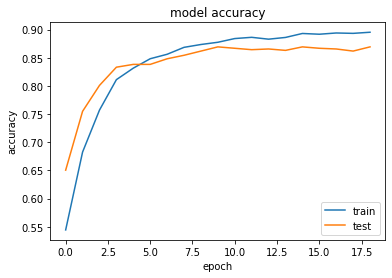

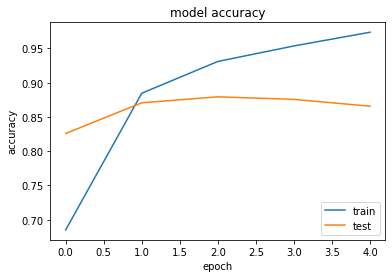

In [ ]:
target_names=['None','Support','Attack']
 
y_pred=[]
y_true=[]

# Assign one-hot encodings to Y values (0,1,2).
categorical_Y = to_categorical(Y_relation_type)

X_supporting_train, X_supporting_test = X_supporting[sections_train_set], X_supporting[sections_test_set]
X_supported_train, X_supported_test = X_supported[sections_train_set], X_supported[sections_test_set]
X_supporting_before_train, X_supporting_before_test = X_supporting_before[sections_train_set], X_supporting_before[sections_test_set]
X_supported_before_train, X_supported_before_test = X_supported_before[sections_train_set], X_supported_before[sections_test_set]
X_supporting_after_train, X_supporting_after_test = X_supporting_after[sections_train_set], X_supporting_after[sections_test_set]
X_supported_after_train, X_supported_after_test = X_supported_after[sections_train_set], X_supported_after[sections_test_set]
X_stat_train, X_stat_test = X_sentence_stat_dataframe[sections_train_set], X_sentence_stat_dataframe[sections_test_set]
Y_train, Y_test = categorical_Y[sections_train_set], categorical_Y[sections_test_set]

# Train the model.
model,model_stat=train_MultiModal(X_supporting_train,X_supported_train,X_supporting_before_train,X_supported_before_train,X_supporting_after_train,X_supported_after_train,X_stat_train,Y_train)

y_pred_temp=model.predict([X_supporting_test,X_supported_test,X_supporting_before_test,X_supported_before_test,X_supporting_after_test,X_supported_after_test,X_stat_test])
for i in range(len(Y_test)):
  y_pred.append(np.argmax(y_pred_temp[i]))
  y_true.append(np.argmax(Y_test[i].tolist()))

In [ ]:
# Print the classification report of the result of the models created
print(classification_report(y_true, y_pred, target_names=target_names))   

              precision    recall  f1-score   support

        None       0.98      0.78      0.87       319
     Support       0.85      0.98      0.91       542
      Attack       0.12      0.04      0.06        28

    accuracy                           0.88       889
   macro avg       0.65      0.60      0.61       889
weighted avg       0.87      0.88      0.87       889



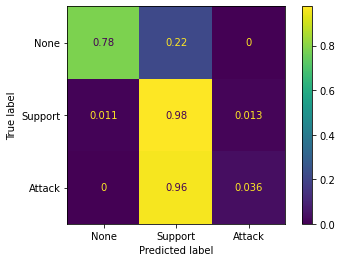

In [ ]:
# Print the confusion matrix.
cm=confusion_matrix(y_true, y_pred,normalize='true')

cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
cm_disp.plot()
plt.show()

## **Stat model results**

In [ ]:
y_pred=[]
y_true=[]

# Transform probabilities predicted in the most probable value (0 or 1).
y_pred_temp=model_stat.predict(X_stat_test).tolist()
for i in range(len(Y_test)):
  y_pred.append(np.argmax(y_pred_temp[i]))
  y_true.append(np.argmax(Y_test[i].tolist()))

In [ ]:
# Print the classification report of the result of the models created
print(classification_report(y_true, y_pred, target_names=target_names)) 

              precision    recall  f1-score   support

        None       0.84      0.92      0.88       319
     Support       0.91      0.88      0.89       542
      Attack       0.07      0.04      0.05        28

    accuracy                           0.87       889
   macro avg       0.61      0.61      0.61       889
weighted avg       0.86      0.87      0.86       889



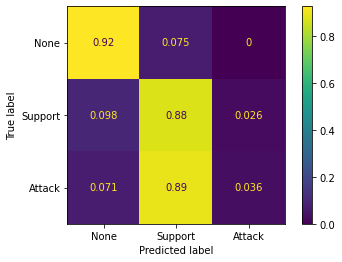

In [ ]:
# Print the confusion matrix.
cm=confusion_matrix(y_true, y_pred,normalize='true')

cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
cm_disp.plot()
plt.show()